In [1]:
#                       _oo0oo_
#                      o8888888o
#                      88" . "88
#                      (| -_- |)
#                      0\  =  /0
#                    ___/`---'\___
#                  .' \\|     |# '.
#                 / \\|||  :  |||# \
#                / _||||| -:- |||||- \
#               |   | \\\  -  #/ |   |
#               | \_|  ''\---/''  |_/ |
#               \  .-\__  '-'  ___/-. /
#             ___'. .'  /--.--\  `. .'___
#          ."" '<  `.___\_<|>_/___.' >' "".
#         | | :  `- \`.;`\ _ /`;.`/ - ` : | |
#         \  \ `_.   \_ __\ /__ _/   .-` /  /
#     =====`-.____`.___ \_____/___.-`___.-'=====
#                       `=---='
#
#
#     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
#               佛祖保佑         永无BUG

In [2]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'

In [450]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

import implicit
from implicit.nearest_neighbours import bm25_weight
from implicit.evaluation import train_test_split, ndcg_at_k, precision_at_k
from scipy.sparse import csr_matrix
from sklearn.neighbors import BallTree
from tqdm import tqdm
from collections import defaultdict
import time
from joblib import Parallel as JoblibParallel, delayed
from sklearn.metrics import auc, roc_auc_score

from dateutil.relativedelta import relativedelta
from functools import partial
import itertools
import scipy.sparse as sp
from scipy.sparse import isspmatrix_csr
from functools import partial

%matplotlib inline

pd.set_option('display.max_columns', 200)

In [4]:
def get_millis_time():
    return int(time.time() * 1000)


def format_time(interval):
    interval = relativedelta(microseconds=(interval * 10 ** 6))
    amounts = interval.days, interval.hours, interval.minutes, interval.seconds, interval.microseconds / 10 ** 3
    result = ' '.join(
        u'{} {}'.format(int(amount), label)
        for amount, label in zip(amounts, ['d', 'h', 'm', 's', 'ms']) if amount
    )
    if not result:
        result = u'0 ms'
    return result


class TimeLatch(object):
    def __init__(self):
        self._start_time = time.time()

    def took(self):
        start_time = self._start_time
        self._start_time = time.time()  # finish time
        return self._start_time - start_time

    def current(self):
        return time.time() - self._start_time

    def took_msg(self):
        return format_time(self.took())

In [5]:
def _norm(array):
    if sp.issparse(array):
        return np.asarray(np.sqrt(array.power(2).sum(axis=1)))
    else:
        return np.linalg.norm(array, axis=1, keepdims=True)

def dot(left, right):
    if isspmatrix_csr(left):
        return np.asarray(left.multiply(right).sum(axis=1))
    return np.multiply(left, right).sum(axis=1, keepdims=True)

def cosine(left, right):
    result = dot(left, right) / (_norm(left) * _norm(right))
    return np.maximum(1. - result, 0.)

def braycurtis(left, right):
    abs_diff = np.abs(left - right)
    abs_sum = np.abs(left + right)
    if sp.issparse(left):
        return 1. * np.asarray(abs_diff.sum(axis=1)) / np.asarray(abs_sum.sum(axis=1))
    else:
        return 1. * abs_diff.sum(axis=1, keepdims=True) / abs_sum.sum(axis=1, keepdims=True)

In [6]:
class Parallel(JoblibParallel):
    def __call__(self, iterable):
        if self.n_jobs == 1:
            return [function(*args, **kwargs) for function, args, kwargs in iterable]
        else:
            return super(Parallel, self).__call__(iterable)

def partition_indices(total, part, nparts):
    if not (0 <= part < nparts):
        raise ValueError()
    part_size = total // nparts
    left = total % nparts
    lower = part_size * part + min(left, part)
    return lower, lower + part_size + (1 if part < left else 0)        
        
def partition(array, nparts):
    return [
        array[left_index:right_index]
        for left_index, right_index in (partition_indices(len(array), part, nparts) for part in range(nparts))
    ]

def _group(group_sizes, *arrays):
    left_index = 0
    for group_size in group_sizes:
        yield [array[left_index:left_index + group_size] for array in arrays]
        left_index += group_size
        
def get_serp_sizes(serp_values):
    serp_values = np.array(serp_values)
    serp_values = serp_values.flatten()
    _, serp_value_idx = np.unique(serp_values, return_index=True)
    return np.diff(np.sort(np.concatenate([serp_value_idx, np.array([len(serp_values)])])))

def _compute_single_ndcg(y_true, y_pred, cut_off=10):
    if cut_off is None:
        cut_off = len(y_true)

    if np.unique(y_true).size == 1:
        return np.nan

    actual = (y_true[np.argsort(-y_pred)])[:cut_off]
    ideal = np.sort(y_true)[::-1][:cut_off]

    size = actual.shape[0]
    denominator = np.log2(np.arange(size) + 2)
    dcg = ((2 ** actual - 1) / denominator).sum()
    idcg = ((2 ** ideal - 1) / denominator).sum()
    return dcg / idcg

def _compute_ndcg(y_true, y_pred, groups, cut_off=10, mean=True):
    ndcg = np.array([
        _compute_single_ndcg(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(ndcg) if mean else ndcg

def _compute_single_mauc(y_true, y_pred):
    if np.unique(y_true).size == 1:
        return np.nan

    return roc_auc_score(y_true, y_pred)

def _compute_mauc(y_true, y_pred, groups, _, mean=True):
    mauc = np.array([
        _compute_single_mauc(group_target, group_pred)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(mauc) if mean else mauc

def _compute_ap(y_true, y_pred, cut_off=10):
    order = np.argsort(-y_pred)
    truth = (y_true[order] > 0.0).astype(float)

    positive = sum(truth)
    if positive == 0.0 or positive == len(truth):
        return np.nan

    cut_off_ = cut_off if cut_off is not None else len(truth)

    denominator = min(cut_off_, positive)
    truth.resize(cut_off_)
    return np.divide(np.multiply(truth, np.cumsum(truth)), 1.0 + np.arange(cut_off_)).sum() / denominator

def _compute_map(y_true, y_pred, groups, cut_off=10, mean=True):
    ap = np.array([
        _compute_ap(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(ap) if mean else ap

def _compute_single_recall(y_true, y_pred, cut_off=10):
    order = np.argsort(-y_pred)
    truth = (y_true[order] > 0.0).astype(float)

    positive = sum(truth)
    if positive == 0.0 or positive == len(truth):
        return np.nan

    cut_off_ = cut_off if cut_off is not None else len(truth)

    denominator = min(cut_off_, positive)
    truth.resize(cut_off_)
    return 1. * truth[:cut_off_].sum() / denominator

def _compute_recall(y_true, y_pred, groups, cut_off=10, mean=True):
    ap = np.array([
        _compute_single_recall(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, y_true, y_pred)
    ])
    return np.nanmean(ap) if mean else ap    


def _prepare_diversity_entities_group(entity, y_pred, cut_off=10):
    order = np.argsort(-y_pred)
    cut_off_ = cut_off if cut_off is not None else len(entity)
    return entity[order][:cut_off]

def _prepare_diversity_entities(entity, y_pred, groups, cut_off=10, mean=True):
    result = [
        _prepare_diversity_entities_group(group_target, group_pred, cut_off)
        for group_target, group_pred in _group(groups, entity, y_pred)
    ]
    return np.hstack(result)  
    
def _compute_ranking_metric(metric_computer, y_true, y_pred, groups, cut_off, mean, ncores):
    groups_parts = partition(groups, ncores)
    metrics = Parallel(n_jobs=ncores)(
        delayed(metric_computer)(y_true_part, y_pred_part, groups_part, cut_off, mean=False)
        for (y_true_part, y_pred_part), groups_part in zip(_group(map(sum, groups_parts), y_true, y_pred), groups_parts)
    )
    metrics = np.hstack(metrics)
    return np.nanmean(metrics) if mean else metrics


def compute_map(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    return _compute_ranking_metric(_compute_map, y_true, y_pred, groups, cut_off, mean, ncores)


def compute_ndcg(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    return _compute_ranking_metric(_compute_ndcg, y_true, y_pred, groups, cut_off, mean, ncores)


def compute_mauc(y_true, y_pred, groups, ncores, cut_off=None, mean=True):
    return _compute_ranking_metric(_compute_mauc, y_true, y_pred, groups, None, mean, ncores)


def compute_recall(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    return _compute_ranking_metric(_compute_recall, y_true, y_pred, groups, cut_off, mean, ncores)


def compute_entropy_diversity(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    entities = _compute_ranking_metric(_prepare_diversity_entities, y_true, y_pred, groups, cut_off, False, ncores)
    counts = pd.DataFrame(entities).value_counts().values
    counts = counts / len(entities)
    return (-counts * np.log(counts)).sum()


def compute_coverage(y_true, y_pred, groups, ncores, cut_off=10, mean=True):
    entities = _compute_ranking_metric(_prepare_diversity_entities, y_true, y_pred, groups, cut_off, False, ncores)
    return len(set(entities))


class Metric(object):
    def __init__(self, name, target='target', pred='pred', group='customer_id', ncores=1):
        self.name = name
        self.target = target
        self.pred = pred
        self.group = group
        self.ncores = ncores

    def compute_score(self, target, prediction, ncores, group=None):
        raise NotImplementedError()
        
    def __call__(self, df):
        pred = df[self.pred]
        target = df[self.target]
        group = df.groupby(self.group).target.count().values
        return self.compute_score(target, pred, self.ncores, group)
        
class RankingCutoffMetric(Metric):
    def __init__(self, name, computer, cut_off=None):
        if cut_off is not None:
            name = '{}@{}'.format(name, cut_off)
        super().__init__(name)
        self.cut_off = cut_off
        self.computer = computer

    def compute_score(self, target, prediction, ncores, group=None):
        if group is None:
            raise ValueError('group must be provided for {}'.format(self.name))
        target = np.array(target)
        prediction = np.array(prediction)
        return self.computer(target, prediction, group, ncores, self.cut_off)
    

class MapMetric(RankingCutoffMetric):
    def __init__(self, cut_off=None):
        super().__init__('map', compute_map, cut_off)


class NdcgMetric(RankingCutoffMetric):
    def __init__(self, cut_off=None):
        super().__init__('ndcg', compute_ndcg, cut_off)


class MeanAucMetric(RankingCutoffMetric):
    def __init__(self):
        super().__init__('mauc', compute_mauc)
        
class RecallMetric(RankingCutoffMetric):
    def __init__(self, cut_off=None):
        super().__init__('recall', compute_recall, cut_off)
        
class EntropyDiversityMetric(RankingCutoffMetric):
    def __init__(self, entity, cut_off=None):
        super().__init__(f'entropy_diversity_of_{entity}', compute_entropy_diversity, cut_off)
        self.ncores = 36
        self.target = entity
        
class CoverageMetric(RankingCutoffMetric):
    def __init__(self, entity, cut_off=None):
        super().__init__(f'coverage_of_{entity}', compute_coverage, cut_off)
        self.ncores = 36
        self.target = entity
        
METRICS = [MeanAucMetric()]
for k in (1, 5, 15):
    METRICS += [NdcgMetric(k), RecallMetric(k),
                EntropyDiversityMetric('chain_id', k), EntropyDiversityMetric('default_product_group_id', k),
                CoverageMetric('chain_id', k), CoverageMetric('default_product_group_id', k)]

In [7]:
df = pd.read_csv('data_made_restaurants.csv')

In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)

# remove customer_id = -10 - as unknown customer
df = df[df['customer_id'] != -10].reset_index(drop=True)

# remove product_group_ids is None - not a restaurants, they are food markets
df = df[~df['product_group_ids'].isnull()].reset_index(drop=True)

In [9]:
# need to remove fastfood from validation
fastfood = {
    'Макдоналдс': df[df['chain_name'] == 'Макдоналдс']['chain_id'].unique().tolist(),
    'KFC': df[df['chain_name'] == 'KFC']['chain_id'].unique().tolist(),
    'Burger King': df[df['chain_name'] == 'Burger King']['chain_id'].unique().tolist(),
}

fastfoold_chains = np.hstack([chain_id for chain_id in fastfood.values()])

df = df[~df['chain_id'].isin(fastfoold_chains)]

In [10]:
# add date features
df['date'] = pd.to_datetime(df['date'])
df['week'] = (df['date'] - df['date'].min()).dt.days // 7

In [11]:
# delete customers with only one order
customer_ids = df.groupby('customer_id')['chain_id'].nunique()
customer_ids = customer_ids[customer_ids > 1].index.tolist()
df = df[df['customer_id'].isin(customer_ids)].reset_index(drop=True)

In [12]:
# compute base features
df.loc[:, 'discount_perc'] = (df['discount_value'] / (df['total_value'] - df['delivery_fee'])).values
df.loc[:, 'total_paid_value'] = (df['total_value']  - df['delivery_fee'] - df['discount_value']).values
df.loc[:, 'total_food_value'] = (df['total_value'] - df['delivery_fee']).values

df.loc[:, 'discount_perc'] = df['discount_perc'].replace(np.inf, 0).clip(0, 1)

In [13]:
# split data on order, customer and vendor entities
pairs = df[['order_id', 'customer_id', 'vendor_id', 'chain_id', 'city_id', 'target',
            'total_value', 'discount_value', 'delivery_fee', 'user_latitude', 'user_longitude',
            'date', 'week', 'discount_perc', 'total_paid_value', 'total_food_value']] 

vendor_data = (df[['vendor_id', 'chain_id', 'chain_name', 'ddk_flag',
                   'vendor_latitude', 'vendor_longitude', 'online_payment', 'accepting_cash',
                   'min_delivery_value', 'takeaway_support', 'citymobil_support',
                   'default_product_group_id', 'product_group_ids', 'cuisine_ids']]
               .drop_duplicates().reset_index(drop=True))

### Сompute behavioural vendor features

In [14]:
vendor_features = (
    pairs
    .pivot_table(index='chain_id', columns='date', values='total_value')
    .unstack()
    .reset_index()
    .sort_values(by=['chain_id', 'date'])
    .reset_index()[['chain_id', 'date']]
)

cols_dct = {
    'order_id': 'count',
    'total_value': 'sum',
    'discount_perc': 'mean',
    'total_paid_value': 'sum',
    'total_food_value': 'sum'
}

# daily features
date_cols = [f'chain_{col}_{func}' for col, func in cols_dct.items()]
date_features = (
    pairs
    .groupby(['chain_id', 'date'])
    .agg(cols_dct)
    .reset_index()
    .rename(columns=dict(zip(list(cols_dct), date_cols)))
)

vendor_features = (
    vendor_features
    .merge(date_features, how='left')
    .fillna(0)
)

# yesterday features
yesterday_cols = [f'{col}_yesterday' for col in date_cols]
vendor_features = pd.concat([
    vendor_features,
    vendor_features
    .groupby('chain_id', sort=False)[date_cols]
    .shift(1)
    .rename(columns=dict(zip(date_cols, yesterday_cols)))
    .reset_index(drop=True)
], axis=1)

# rolling features
rolling_cols = [f'{col}_rolling14_mean' for col in date_cols]
vendor_features = pd.concat([
    vendor_features,
    vendor_features
    .groupby('chain_id', sort=False)[yesterday_cols]
    .rolling(14)
    .mean()
    .rename(columns=dict(zip(yesterday_cols, rolling_cols)))
    .reset_index(drop=True)
], axis=1)

In [15]:
print(vendor_features.shape)
vendor_features.head()

(1184500, 17)


,chain_id,date,chain_order_id_count,chain_total_value_sum,chain_discount_perc_mean,chain_total_paid_value_sum,chain_total_food_value_sum,chain_order_id_count_yesterday,chain_total_value_sum_yesterday,chain_discount_perc_mean_yesterday,chain_total_paid_value_sum_yesterday,chain_total_food_value_sum_yesterday,chain_order_id_count_rolling14_mean,chain_total_value_sum_rolling14_mean,chain_discount_perc_mean_rolling14_mean,chain_total_paid_value_sum_rolling14_mean,chain_total_food_value_sum_rolling14_mean
0,26,2020-08-01,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,2020-08-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,26,2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,26,2020-08-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,26,2020-08-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [16]:
# vendor_features.to_parquet('vendor_features.parquet')

In [17]:
# vendor_features = pd.read_parquet('vendor_features.parquet')

### Сompute behavioural customer features

In [252]:
def moving_group_agg_features(data, group_column, value_column, aggregate_functions):
    data[f'last_{value_column}'] = data.groupby(group_column)[value_column].shift()
    feature_names = [f'{agg_func}_{value_column}' for agg_func in aggregate_functions]
    feature_values = data.groupby(group_column)[f'last_{value_column}'].expanding().agg(aggregate_functions).values
    data[feature_names] = feature_values

def get_onehot_df(order_df, index_names, column_name, prefix):
    orders = (
        order_df[index_names + [column_name]]
        .copy()
        .explode(column_name)
        .dropna()
        .reset_index(drop=True)
    )
    
    onehot = pd.pivot_table(data=orders,
                            index=index_names,
                            columns=column_name,
                            aggfunc='size')
    onehot.columns.name = None
    onehot = onehot.reset_index()
    key_data = (
        order_df[index_names]
        .drop_duplicates(keep='first')
        .reset_index()
        .merge(onehot, on=index_names, how='left')
    )
    
    features = (
        key_data
        .groupby('customer_id')
        .rolling('30d', on='date', closed='left')[onehot.columns[1:]]
        .sum()
        .fillna(0)
    )
    
    features.columns = [f'cumcount_{prefix}_{col}_roll_30d' for col in onehot.columns[2:]]
    features = features.reset_index()
    return features

In [251]:
df = df.sort_values(by=['customer_id', 'date', 'order_id']).reset_index(drop=True)

In [20]:
df['cuisine_ids'] = df['cuisine_ids'].apply(lambda row: eval(row) if pd.notnull(row) else np.nan)
df['product_group_ids'] = df['product_group_ids'].apply(lambda row: eval(row) if pd.notnull(row) else np.nan)

In [21]:
agg_dct = {'total_value': ['sum'], 
           'discount_value': ['sum'], 
           'delivery_fee': ['sum'], 
           'discount_perc': ['mean'], 
           'total_paid_value': ['sum'],
           'total_food_value': ['sum'],
           'target': ['sum']}


customer_group_cols = ['customer_id', 'date']
customer_daily_data = df.groupby(customer_group_cols).agg(agg_dct).reset_index()
customer_daily_data.columns = customer_daily_data.columns.get_level_values(0)
customer_daily_data = customer_daily_data.sort_values(by=customer_group_cols).reset_index(drop=True)

In [22]:
customer_daily_data['days_from_last_order'] = customer_daily_data.groupby('customer_id')['date'].diff().dt.days

In [256]:
customer_daily_data['cumcount_orders_roll_30d'] = (
    customer_daily_data
    .groupby('customer_id')
    .rolling('30d', on='date', closed='left')['target']
    .sum()
    .fillna(0)
    .values
)

In [257]:
aggregate_columns = ['total_value', 'discount_value', 'delivery_fee',
                     'discount_perc', 'total_paid_value', 'total_food_value']
aggregate_functions = ['min', 'mean', 'median', 'max']
group_column = 'customer_id'
time_column = 'date'

customer_rolling_data = (
    customer_daily_data
    .groupby(group_column)
    .rolling('30d', on='date', closed='left')[aggregate_columns]
    .agg(aggregate_functions)
    .fillna(0)
).values

zip_col_names = list(itertools.product(aggregate_columns, aggregate_functions))
customer_rolling_columns = [f'{val}_{agg}_roll_30d' for val, agg in zip_col_names]
customer_daily_data[customer_rolling_columns] = customer_rolling_data

In [258]:
index_names = ['customer_id', 'date']
column_name = 'cuisine_ids'
prefix = 'cuisine_id'

cuisine_onehot_features = get_onehot_df(df, index_names, column_name, prefix)

In [259]:
column_name = 'product_group_ids'
prefix = 'product_group_id'

product_onehot_features = get_onehot_df(df, index_names, column_name, prefix)

In [260]:
customer_features = (
    customer_daily_data
    .merge(cuisine_onehot_features, on=index_names, how='left')
    .merge(product_onehot_features, on=index_names, how='left')
)

In [261]:
customer_features = customer_features[
    [col for col in customer_features.columns if col not in aggregate_columns + ['target']]
]

In [29]:
print(customer_features.shape)
customer_features.head()

(557007, 78)


,customer_id,date,days_from_last_order,cumcount_orders_roll_14d,total_value_min_roll_14d,total_value_mean_roll_14d,total_value_median_roll_14d,total_value_max_roll_14d,discount_value_min_roll_14d,discount_value_mean_roll_14d,discount_value_median_roll_14d,discount_value_max_roll_14d,delivery_fee_min_roll_14d,delivery_fee_mean_roll_14d,delivery_fee_median_roll_14d,delivery_fee_max_roll_14d,discount_perc_min_roll_14d,discount_perc_mean_roll_14d,discount_perc_median_roll_14d,discount_perc_max_roll_14d,total_paid_value_min_roll_14d,total_paid_value_mean_roll_14d,total_paid_value_median_roll_14d,total_paid_value_max_roll_14d,total_food_value_min_roll_14d,total_food_value_mean_roll_14d,total_food_value_median_roll_14d,total_food_value_max_roll_14d,cumcount_cuisine_id_1_roll_14d,cumcount_cuisine_id_2_roll_14d,cumcount_cuisine_id_3_roll_14d,cumcount_cuisine_id_4_roll_14d,cumcount_cuisine_id_5_roll_14d,cumcount_cuisine_id_6_roll_14d,cumcount_cuisine_id_22_roll_14d,cumcount_cuisine_id_23_roll_14d,cumcount_cuisine_id_25_roll_14d,cumcount_cuisine_id_26_roll_14d,cumcount_cuisine_id_28_roll_14d,cumcount_cuisine_id_29_roll_14d,cumcount_product_group_id_1_roll_14d,cumcount_product_group_id_2_roll_14d,cumcount_product_group_id_3_roll_14d,cumcount_product_group_id_5_roll_14d,cumcount_product_group_id_6_roll_14d,cumcount_product_group_id_18_roll_14d,cumcount_product_group_id_19_roll_14d,cumcount_product_group_id_20_roll_14d,cumcount_product_group_id_21_roll_14d,cumcount_product_group_id_22_roll_14d,cumcount_product_group_id_23_roll_14d,cumcount_product_group_id_24_roll_14d,cumcount_product_group_id_25_roll_14d,cumcount_product_group_id_26_roll_14d,cumcount_product_group_id_27_roll_14d,cumcount_product_group_id_28_roll_14d,cumcount_product_group_id_29_roll_14d,cumcount_product_group_id_30_roll_14d,cumcount_product_group_id_31_roll_14d,cumcount_product_group_id_32_roll_14d,cumcount_product_group_id_33_roll_14d,cumcount_product_group_id_34_roll_14d,cumcount_product_group_id_35_roll_14d,cumcount_product_group_id_36_roll_14d,cumcount_product_group_id_37_roll_14d,cumcount_product_group_id_38_roll_14d,cumcount_product_group_id_39_roll_14d,cumcount_product_group_id_40_roll_14d,cumcount_product_group_id_41_roll_14d,cumcount_product_group_id_42_roll_14d,cumcount_product_group_id_43_roll_14d,cumcount_product_group_id_44_roll_14d,cumcount_product_group_id_45_roll_14d,cumcount_product_group_id_47_roll_14d,cumcount_product_group_id_48_roll_14d,cumcount_product_group_id_49_roll_14d,cumcount_product_group_id_51_roll_14d,cumcount_product_group_id_52_roll_14d
0,86,2020-10-03,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,86,2020-10-13,10.0,1.0,427.0,427.0,427.0,427.0,82.0,82.0,82.0,82.0,99.0,99.0,99.0,99.0,0.25,0.25,0.25,0.25,246.0,246.0,246.0,246.0,328.0,328.0,328.0,328.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,219,2020-08-13,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,219,2020-10-05,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,350,2020-10-07,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.

In [30]:
# customer_features.to_parquet('customer_features.parquet')

In [31]:
# customer_features = pd.read_parquet('customer_features.parquet')

In [381]:
sorted(df.week.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

### Validation

In [390]:
def split_by_folds(df):
    # split data on train and validation
    folds = {
        'test': df[df['week'] >= 11].index.tolist(),
        'train': df[(df['week'] >= 4) & (df['week'] < 11)].index.tolist(),
    }
    
    # train - 4 weeks, val - 1 week
    for fold_num, week in enumerate(range(0, 7, 3)):
        fold_train = df[(df['week'] >= week) & (df['week'] < (week + 4))]
        folds[f'train_{fold_num + 1}'] = fold_train.index.values
        
        fold_val = df[(df['week'] == (week + 4)) 
                      & (~df['chain_id'].isin(fastfoold_chains))] # remove fastfood from validation
        
        fold_val_index = fold_val.index.values
            
        # remove train orders from validation
        tmp = fold_train[['customer_id', 'chain_id']].drop_duplicates()
        tmp['is_in_train'] = 1
        fold_val = fold_val.merge(tmp, how='left')
        
        folds[f'val_{fold_num + 1}'] = fold_val_index[fold_val['is_in_train'].isnull()]
        
    return folds

In [33]:
def build_vendor_tree(df):
    # bulld data structure for fast geo search
    vendor_coords = df[['vendor_id', 'vendor_latitude', 'vendor_longitude']].drop_duplicates()
    
    tree = BallTree(np.radians(vendor_coords[['vendor_latitude', 'vendor_longitude']]), 
                    leaf_size=40, metric='haversine')
    
    return tree, vendor_coords

In [34]:
def sample_zeros(tree, pairs, vendor_coords, radius=5000, n_samples=100):
    # sample zeros as vendor_ids within some radius
    R = 6367000
    ind, dist = tree.query_radius(
        np.radians(pairs[['user_latitude', 'user_longitude']]), r=radius/R, return_distance=True)
    
    zeros = []
    vendor_coords_values = vendor_coords['vendor_id'].values
    cols = ['customer_id', 'date', 'user_latitude', 'user_longitude', 'city_id']
    
    for i, (customer_id, date, lat, lon, city) in enumerate(pairs[cols].values):
        vendors = ind[i]
        if n_samples:
            vendors = np.random.choice(ind[i], size=min(len(vendors), n_samples), replace=False)
        zeros += [(customer_id, vendor, date, lat, lon, city, 0) for vendor in vendor_coords_values[vendors]]
        
    return pd.DataFrame(zeros, columns=['customer_id', 'vendor_id', 'date',
                                        'user_latitude', 'user_longitude', 'city_id', 'target'])

In [35]:
def add_zeros_to_folds(fold, pairs_zeros):
    
    fold = pd.concat([fold, 
                      pairs_zeros[pairs_zeros['customer_id'].isin(fold['customer_id'])
                                 & (pairs_zeros['date'] >= fold['date'].min())
                                 & (pairs_zeros['date'] <= fold['date'].max())]], axis=0)
    fold.drop_duplicates(subset=['customer_id', 'chain_id', 'target'], inplace=True)
    fold = (fold.groupby(['customer_id', 'chain_id'])['target'].max().reset_index()
            .merge(fold))
    return fold

In [36]:
tree, vendor_coords = build_vendor_tree(vendor_data)

In [37]:
pairs_zeros_train = sample_zeros(tree, pairs, vendor_coords, n_samples=100)

# pairs_zeros_val = sample_zeros(tree, customer_data, vendor_coords, n_samples=None)

In [38]:
# add chain_id to sampled zeros (vendor_ids)
pairs_zeros_train = pairs_zeros_train.merge(vendor_data[['vendor_id', 'chain_id']].drop_duplicates())

# pairs_zeros_val = (pairs_zeros_val
#                .merge(vendor_data[['vendor_id', 'chain_id']].drop_duplicates()))

In [39]:
print(pairs_zeros_train.shape)
pairs_zeros_train.head()

(49713195, 8)


,customer_id,vendor_id,date,user_latitude,user_longitude,city_id,target,chain_id
0,15955880,267406,2020-08-01,55.7815,37.5307,1,0,50738
1,85014577,267406,2020-08-03,55.7713,37.5840,1,0,50738
2,14636867,267406,2020-08-04,55.7347,37.4908,1,0,50738
3,65920510,267406,2020-09-12,55.7347,37.4908,1,0,50738
4,76331931,267406,2020-10-06,55.7498,37.5903,1,0,50738


In [391]:
folds = split_by_folds(pairs)

In [41]:
# pairs_zeros_train.to_parquet('pairs_zeros_train.parquet')

In [42]:
# pairs_zeros_train = pd.read_parquet('pairs_zeros_train.parquet')

### Cuisine Predicted

In [845]:
cuisine_df = pd.read_csv('chain_cuisines_restored.txt')

In [847]:
df = df.merge(cuisine_df[['chain_id', 'cuisines_predicted']], how='left')

In [859]:
train = train.merge(cuisine_df[['chain_id', 'cuisines_predicted']], how='left')
test = test.merge(cuisine_df[['chain_id', 'cuisines_predicted']], how='left')

### Graph Embedding

In [43]:
import node2vec
import networkx as nx
import itertools
from collections import defaultdict

In [840]:
class GraphEmbeddings:
    def __init__(self, df, dims, threshold):
        self.df = df[['customer_id', 'chain_id']].copy()
        self.dims = dims
        self.threshold = threshold
        self.G = None
        self.model = None
        
    def _prepare_graph(self):
        print('start graph construction')
        latch = TimeLatch()
        group = self.df.groupby('customer_id').chain_id.apply(set)
        edges = defaultdict(int)
        for chain_ids in tqdm(group.values):
            for pair in itertools.combinations(chain_ids, 2):
                edges[tuple(sorted(pair))] += 1
        print(f'number of edges: {len(edges)}')
        p = np.percentile(np.array(list(edges.values())), [1, 5, 10])
        print(f'weight percentiles: 1 - {p[0]}; 5 - {p[1]}; 10 - {p[2]}')
        self.G = nx.Graph()
        for k, v in  edges.items():
            if v >= self.threshold:
                self.G.add_edge(*k, weight=np.log1p(v))
        print(f'graph constructed, took {latch.took_msg()}')
        print(nx.info(self.G))
            
    def fit(self):
        self._prepare_graph()
        print('start fitting the model')
        latch = TimeLatch()
        n2v = node2vec.Node2Vec(self.G, dimensions=self.dims)
        self.model = n2v.fit()
        print(f'model has been fitted, took {latch.took_msg()}')
        
    def transform(self, df):
        idx = np.array(self.model.wv.index2word, dtype=int)
        idx = pd.Series(index=idx, data=np.arange(len(idx)), name='idx')
        idx = pd.merge(df['chain_id'], idx, left_on='chain_id', right_index=True, how='left')
        vecs = np.vstack([self.model.wv.vectors, np.zeros(shape=(1,self.dims), dtype=np.float)])
        idx.loc[np.isnan(idx['idx']), 'idx'] = vecs.shape[0] - 1
        return vecs[idx['idx'].values.astype(np.int32)]
        

In [841]:
previous_train = df[df.week < pairs.loc[folds['train']].week.min()]
previous_test = df[(df.week < pairs.loc[folds['test']].week.min()) & 
                                    (df.week >= pairs.loc[folds['test']].week.min() - 4)]

emb_graph_train = GraphEmbeddings(previous_train, threshold=0, dims=64)
emb_graph_train.fit()

emb_graph_test = GraphEmbeddings(previous_test, threshold=0, dims=64)
emb_graph_test.fit()

start graph construction


Computing transition probabilities:   0%|          | 0/8037 [00:00<?, ?it/s]

number of edges: 32100
weight percentiles: 1 - 1.0; 5 - 1.0; 10 - 1.0
graph constructed, took 2 s 97 ms
Name: 
Type: Graph
Number of nodes: 8037
Number of edges: 32100
Average degree:   7.9881
start fitting the model


Generating walks (CPU: 1): 100%|██████████| 10/10 [05:06<00:00, 30.63s/it]


model has been fitted, took 6 m 196 ms
start graph construction


Computing transition probabilities:   0%|          | 0/8952 [00:00<?, ?it/s]

number of edges: 39646
weight percentiles: 1 - 1.0; 5 - 1.0; 10 - 1.0
graph constructed, took 2 s 360 ms
Name: 
Type: Graph
Number of nodes: 8952
Number of edges: 39646
Average degree:   8.8575
start fitting the model


Generating walks (CPU: 1): 100%|██████████| 10/10 [05:44<00:00, 34.43s/it]


model has been fitted, took 6 m 49 s 204 ms


In [851]:
def to_onehot(l, size):
    h = np.zeros(size + 1, dtype=np.float32)
    if isinstance(l, list):
        h[l] = 1.
        return h    
    elif isinstance(l, str):
        l = [int(x.replace(',', '')) for x in l[1:-1].split()]
    elif pd.isnull(l):
        return h
    h[l] = 1.
    return h

def hist_graph_emb_mean(df, emb_graph):
    cumemb = emb_graph.transform(df).cumsum(axis=0)
    cumemb = cumemb[:-1] / np.arange(1, df.shape[0])[:,None]
    return np.vstack([np.zeros(shape=(1, emb_graph.dims), dtype=np.float), cumemb])  

def hist_graph_emb_last(df, emb_graph):
    return np.vstack([np.zeros(shape=(1, emb_graph.dims), dtype=np.float), emb_graph.transform(df)[:-1]])  

def hist_product_ids_last(df):
    ohe = np.vstack(df['product_group_ids'].apply(partial(to_onehot, size=52)).values)
    return np.vstack([np.zeros(shape=(1, 53), dtype=np.float), ohe[:-1]])  

def hist_product_ids_mean(df):    
    ohe = np.vstack(df['product_group_ids'].apply(partial(to_onehot, size=52)).values)
    cols = [f'col_{i}' for i in range(ohe.shape[1])]
    df[cols] = ohe
    x = df.rolling('30d', on='date', closed='left')[cols].mean()
    return x[cols].values

def hist_cuisine_ids_last(df):
    ohe = np.vstack(df['cuisine_ids'].apply(partial(to_onehot, size=30)).values)
    return np.vstack([np.zeros(shape=(1, 31), dtype=np.float), ohe[:-1]])  

def hist_cuisine_ids_mean(df):    
    ohe = np.vstack(df['cuisine_ids'].apply(partial(to_onehot, size=30)).values)
    cols = [f'col_{i}' for i in range(ohe.shape[1])]
    df[cols] = ohe
    x = df.rolling('30d', on='date', closed='left')[cols].mean()
    return x[cols].values


def hist_cuisine_pred_ids_last(df):
    ohe = np.vstack(df['cuisines_predicted'].apply(partial(to_onehot, size=30)).values)
    return np.vstack([np.zeros(shape=(1, 31), dtype=np.float), ohe[:-1]])  

def hist_cuisine_pred_ids_mean(df):    
    ohe = np.vstack(df['cuisines_predicted'].apply(partial(to_onehot, size=30)).values)
    cols = [f'col_{i}' for i in range(ohe.shape[1])]
    df[cols] = ohe
    x = df.rolling('30d', on='date', closed='left')[cols].mean()
    return x[cols].values


def hist_graph_emb_sum(df, emb_graph):
    cumemb = emb_graph.transform(df).cumsum(axis=0)
    cumemb = cumemb[:-1] / np.arange(1, df.shape[0])[:,None]
    return np.vstack([np.zeros(shape=(1, emb_graph.dims), dtype=np.float), cumemb])  

def _compute_historical_feature(feature_computer, df, groups):
    values = [
        feature_computer(group[0]) for group in _group(groups, df)
    ]
    return np.vstack(values)

def compute_historical_feature(feature_computer, df, ncores):   
    groups = get_serp_sizes(df['customer_id'])
    groups_parts = partition(groups, ncores)
    features = Parallel(n_jobs=ncores)(
        delayed(_compute_historical_feature)(feature_computer, df_part[0], groups_part)
        for df_part, groups_part in zip(_group(map(sum, groups_parts), df), groups_parts)
    )    
    return np.vstack(features)

In [842]:
user_emb_mean_train = compute_historical_feature(partial(hist_graph_emb_mean, emb_graph=emb_graph_train), df, 36)
user_emb_mean_test = compute_historical_feature(partial(hist_graph_emb_mean, emb_graph=emb_graph_test), df, 36)
user_emb_last_train = compute_historical_feature(partial(hist_graph_emb_last, emb_graph=emb_graph_train), df, 36)
user_emb_last_test = compute_historical_feature(partial(hist_graph_emb_last, emb_graph=emb_graph_test), df, 36)

In [831]:
user_hist_product_ids_last = compute_historical_feature(hist_product_ids_last, df, 36)
user_hist_product_ids_mean = compute_historical_feature(hist_product_ids_mean, df, 36)
user_hist_cuisine_ids_last = compute_historical_feature(hist_cuisine_ids_last, df, 36)
user_hist_cuisine_ids_mean = compute_historical_feature(hist_cuisine_ids_mean, df, 36)

In [852]:
user_hist_cuisine_pred_ids_last = compute_historical_feature(hist_cuisine_pred_ids_last, df, 36)
user_hist_cuisine_pred_ids_mean = compute_historical_feature(hist_cuisine_pred_ids_mean, df, 36)

In [738]:
user_emb_index = df[['customer_id', 'date']].reset_index().copy()
user_emb_index.columns = ['num', 'customer_id', 'date']
user_emb_index = user_emb_index.groupby(['customer_id', 'date'])['num'].min().reset_index()

In [806]:
def add_graph_emb_hist_features(df, name, emb_graph, user_emb, user_emb_index):  
    df['order'] = np.arange(df.shape[0])    
    user_vals = user_emb[df.merge(user_emb_index, on=['customer_id', 'date']).sort_values('order').num]
   
    df[f'cos_hist_graph_emb_{name}'] = cosine(user_vals, emb_graph.transform(df))
    df[f'bc_hist_graph_emb_{name}'] = braycurtis(user_vals, emb_graph.transform(df))
    df[f'dot_hist_graph_emb_{name}'] = dot(user_vals, emb_graph.transform(df))

In [857]:
def add_products_ohe_features(df, name, user_emb, user_emb_index):    
    df['order'] = np.arange(df.shape[0])    
    user_vals = user_emb[df.merge(user_emb_index, on=['customer_id', 'date']).sort_values('order').num]
    
    chain_vals = np.vstack(df['product_group_ids'].apply(partial(to_onehot, size=52)).values)
    
    df[f'cos_hist_products_ohe_{name}'] = cosine(user_vals, chain_vals)
    df[f'bc_hist_products_ohe_{name}'] = braycurtis(user_vals, chain_vals)
    df[f'dot_hist_products_ohe_{name}'] = dot(user_vals, chain_vals)
    
def add_cuisines_ohe_features(df, name, user_emb, user_emb_index):    
    df['order'] = np.arange(df.shape[0])    
    user_vals = user_emb[df.merge(user_emb_index, on=['customer_id', 'date']).sort_values('order').num]
    
    chain_vals = np.vstack(df['cuisine_ids'].apply(partial(to_onehot, size=30)).values)
    
    df[f'cos_hist_cuisines_ohe_{name}'] = cosine(user_vals, chain_vals)
    df[f'bc_hist_cuisines_ohe_{name}'] = braycurtis(user_vals, chain_vals)
    df[f'dot_hist_cuisines_ohe_{name}'] = dot(user_vals, chain_vals)
    
def add_cuisines_pred_ohe_features(df, name, user_emb, user_emb_index):    
    df['order'] = np.arange(df.shape[0])    
    user_vals = user_emb[df.merge(user_emb_index, on=['customer_id', 'date']).sort_values('order').num]
    
    chain_vals = np.vstack(df['cuisines_predicted'].apply(partial(to_onehot, size=30)).values)
    
    df[f'cos_hist_cuisines_pred_ohe_{name}'] = cosine(user_vals, chain_vals)
    df[f'bc_hist_cuisines_pred_ohe_{name}'] = braycurtis(user_vals, chain_vals)
    df[f'dot_hist_cuisines_pred_ohe_{name}'] = dot(user_vals, chain_vals)

### Feature engineering

In [52]:
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367000 * c
    return km

def create_features(pairs, vendor_data, vendor_features, customer_features):
    # add source vendor features
    pairs = pairs.merge(vendor_data, on=['chain_id', 'vendor_id'])

    # add vendor behavioural features
    pairs = pairs.merge(vendor_features, on=['chain_id', 'date'])

    # add customer behavioural features
    pairs = pairs.merge(customer_features, on=['customer_id', 'date'])

    # add simple features
    pairs['distance'] = haversine(pairs['user_latitude'], pairs['user_longitude'],
                                  pairs['vendor_latitude'], pairs['vendor_longitude']).round(-2)
    pairs['min_delivery_value'] = pairs['min_delivery_value'].round(-3)
    pairs['day_of_week'] = pairs['date'].dt.dayofweek

    # sort data for lambdamart
    pairs.sort_values(by=['customer_id', 'chain_id', 'target'], inplace=True)
    return pairs

In [866]:
# customer_feats = [col for col in customer_features.columns if col not in ['customer_id', 'date']]

customer_feats = [
#  'days_from_last_order', # надо бы ограничить окном
 'cumcount_orders_roll_30d',
 'total_value_min_roll_30d',
 'total_value_mean_roll_30d',
 'total_value_median_roll_30d',
 'total_value_max_roll_30d',
 'discount_value_min_roll_30d',
 'discount_value_mean_roll_30d',
 'discount_value_median_roll_30d',
 'discount_value_max_roll_30d',
]

vendor_feats = [
    # behavioural vendor features
    'chain_order_id_count_yesterday',
    'chain_total_value_sum_yesterday', 
    'chain_discount_perc_mean_yesterday',
    'chain_total_paid_value_sum_yesterday',
    'chain_total_food_value_sum_yesterday',
    'chain_order_id_count_rolling14_mean',
    'chain_total_value_sum_rolling14_mean',
    'chain_discount_perc_mean_rolling14_mean',
    'chain_total_paid_value_sum_rolling14_mean',
    'chain_total_food_value_sum_rolling14_mean',    
]

product_id_ohe_features = [
    'cos_hist_products_ohe_mean',
    'bc_hist_products_ohe_mean',
    'dot_hist_products_ohe_mean',
    'cos_hist_products_ohe_last',
    'bc_hist_products_ohe_last',
    'dot_hist_products_ohe_last',
]

cuisine_id_ohe_features = [
    'cos_hist_cuisines_ohe_mean',
    'bc_hist_cuisines_ohe_mean',
    'dot_hist_cuisines_ohe_mean',
    'cos_hist_cuisines_ohe_last',
    'bc_hist_cuisines_ohe_last',
    'dot_hist_cuisines_ohe_last',
]

cuisine_pred_id_ohe_features = [
    'cos_hist_cuisines_pred_ohe_mean',
    'bc_hist_cuisines_pred_ohe_mean',
    'dot_hist_cuisines_pred_ohe_mean',
    'cos_hist_cuisines_pred_ohe_last',
    'bc_hist_cuisines_pred_ohe_last',
    'dot_hist_cuisines_pred_ohe_last',
]

graph_emb_features = [
    'cos_hist_graph_emb_mean',
    'bc_hist_graph_emb_mean',
    'dot_hist_graph_emb_mean',
    'cos_hist_graph_emb_last',
    'bc_hist_graph_emb_last',
    'dot_hist_graph_emb_last'
]

feats = [
    # source order features
    'user_latitude', 'user_longitude', 
    'city_id', 
    
    # source vendor features
    'vendor_latitude', 'vendor_longitude', 
    'ddk_flag', 'online_payment', 'accepting_cash',
    'min_delivery_value', 'takeaway_support', 'citymobil_support', 'default_product_group_id', 
    
    # simple features
    'distance',
    'day_of_week'
] 

# feats += customer_feats  
# feats += product_id_ohe_features
# feats += cuisine_id_ohe_features
# feats += cuisine_pred_id_ohe_features
# feats += graph_emb_features


### Train

In [834]:
def prepare_fold(pairs, pairs_zeros, vendor_features, customer_features, distance=5000):
    pairs = add_zeros_to_folds(pairs, pairs_zeros)
    pairs = create_features(pairs, vendor_data, vendor_features, customer_features)
    
    # remove target with distance greater than sampled for train
    pairs = pairs[pairs['distance'] < distance]
    pairs = pairs[pairs.groupby('customer_id')['target'].transform('sum') > 0]
    return pairs

In [511]:
# validate on test
pairs_feats = pairs_zeros_train.columns.tolist() 

train = prepare_fold(pairs.loc[folds['train'], pairs_feats], pairs_zeros_train, vendor_features, customer_features)
test = prepare_fold(pairs.loc[folds['test'], pairs_feats], pairs_zeros_train, vendor_features, customer_features)

In [843]:
add_graph_emb_hist_features(train, 'mean', emb_graph_train, user_emb_mean_train, user_emb_index)
add_graph_emb_hist_features(test, 'mean', emb_graph_test, user_emb_mean_test, user_emb_index)

add_graph_emb_hist_features(train, 'last', emb_graph_train, user_emb_last_train, user_emb_index)
add_graph_emb_hist_features(test, 'last', emb_graph_test, user_emb_last_test, user_emb_index)

In [836]:
add_products_ohe_features(train, 'last', user_hist_product_ids_last, user_emb_index)
add_products_ohe_features(test, 'last', user_hist_product_ids_last, user_emb_index)
add_products_ohe_features(train, 'mean', user_hist_product_ids_mean, user_emb_index)
add_products_ohe_features(test, 'mean', user_hist_product_ids_mean, user_emb_index)

add_cuisines_ohe_features(train, 'last', user_hist_cuisine_ids_last, user_emb_index)
add_cuisines_ohe_features(test, 'last', user_hist_cuisine_ids_last, user_emb_index)
add_cuisines_ohe_features(train, 'mean', user_hist_cuisine_ids_mean, user_emb_index)
add_cuisines_ohe_features(test, 'mean', user_hist_cuisine_ids_mean, user_emb_index)

In [860]:
add_cuisines_pred_ohe_features(train, 'last', user_hist_cuisine_pred_ids_last, user_emb_index)
add_cuisines_pred_ohe_features(test, 'last', user_hist_cuisine_pred_ids_last, user_emb_index)
add_cuisines_pred_ohe_features(train, 'mean', user_hist_cuisine_pred_ids_mean, user_emb_index)
add_cuisines_pred_ohe_features(test, 'mean', user_hist_cuisine_pred_ids_mean, user_emb_index)

In [426]:
lgb_params = {
    'num_boost_round': 1000,
    'early_stopping_round': 50,
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'eval_at': [15],
    'verbosity': 1,
#     'max_position': 15,
    'lambdamart_norm': True,
    'eta': 0.1,
    'max_depth': 8,
    'min_data_in_leaf': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 1,
    'seed': 42,
    'nthread': 36
}

In [862]:
def ddata(feats):
    dtrain = lgb.Dataset(train[feats], label=train['target'],
                         group=train.groupby('customer_id')['target'].count().values)
    dval = lgb.Dataset(test[feats], label=test['target'],
                       group=test.groupby('customer_id')['target'].count().values)
    return dtrain, dval

In [868]:
def train_and_eval(feats):
    dtrain, dval = ddata(feats)
    evals_res = {}
    model = lgb.train(lgb_params, dtrain, valid_sets=[dtrain, dval], evals_result=evals_res, verbose_eval=50)
    test['pred'] = model.predict(test[feats])
    for metric in METRICS:
        print(f'{metric.name}: {metric(test)}')
    lgb.plot_importance(model, figsize=(12, 10))

[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.621496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 16427174, number of used features: 14
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@1

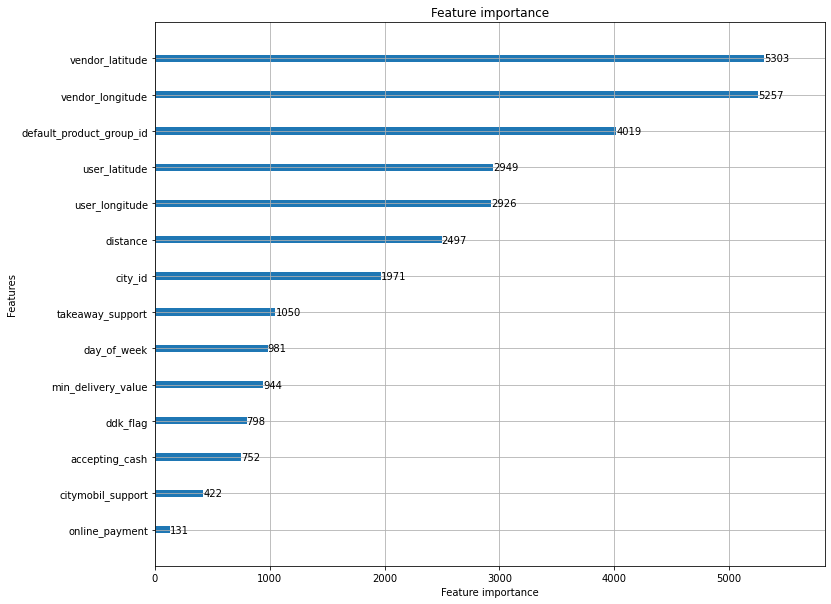

In [869]:
train_and_eval(feats)

[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.300833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5768
[LightGBM] [Info] Number of data points in the train set: 16427174, number of used features: 33
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@1

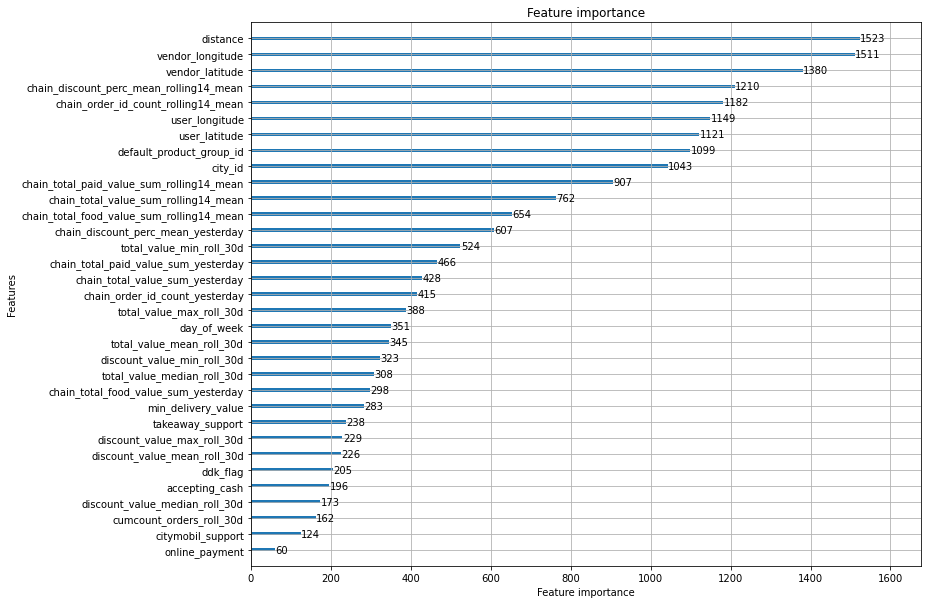

In [870]:
feats += customer_feats 
feats += vendor_feats
train_and_eval(feats)

[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.343941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6345
[LightGBM] [Info] Number of data points in the train set: 16427174, number of used features: 39
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@1

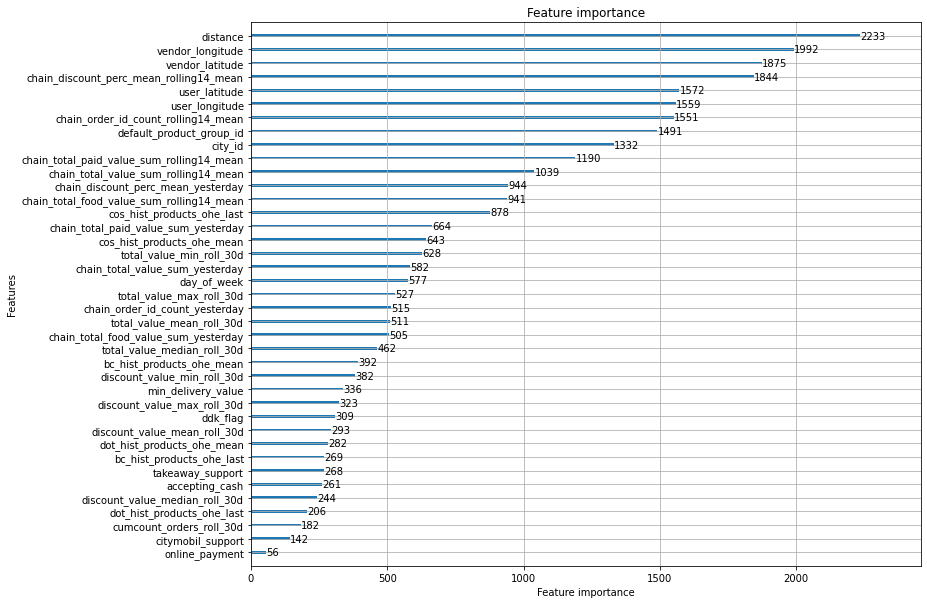

In [871]:
feats += product_id_ohe_features
train_and_eval(feats)

[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.616169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6669
[LightGBM] [Info] Number of data points in the train set: 16427174, number of used features: 45
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@1

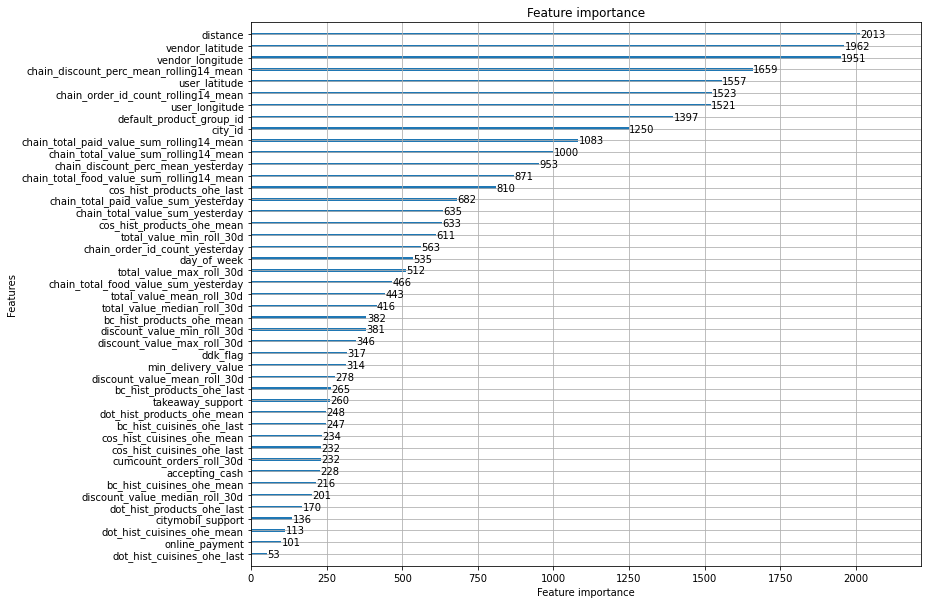

In [872]:
feats += cuisine_id_ohe_features
train_and_eval(feats)

[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.348499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 16427174, number of used features: 51
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@1

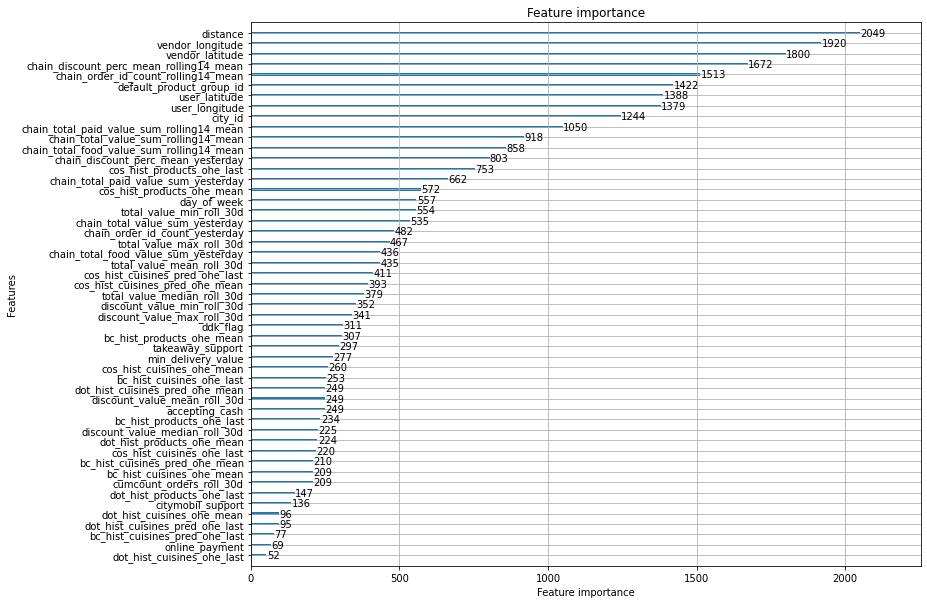

In [877]:
feats += cuisine_pred_id_ohe_features
train_and_eval(feats)

[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.507974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8740
[LightGBM] [Info] Number of data points in the train set: 16427174, number of used features: 57
[LightGBM] [Warning] Unknown parameter: lambdamart_norm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@1

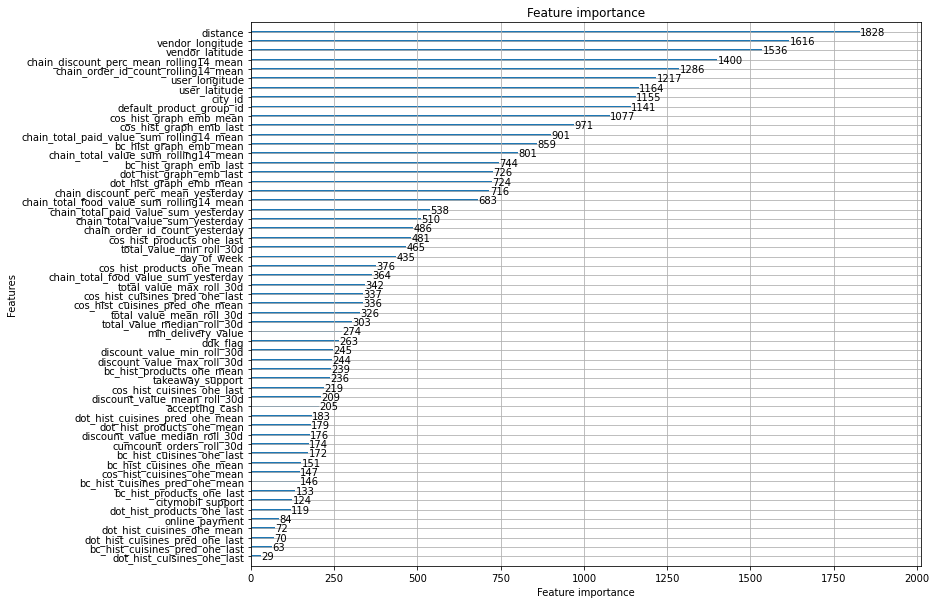

In [878]:
feats += graph_emb_features
train_and_eval(feats)

||MAUC|Recall@15|NDCG@15|DIV_PROD@15|DIV_CHAIN@15|COV_CHAIN@15|
|:---|---|---|---|---|---|---|
|RAND|0.4993|0.2133|0.0883|2.8941|8.9504|12831|
|ALS_BASELINE|0.6874|0.4706|0.2847|**2.8863**|**8.3969**|**12168**|
|LGBM_BASELINE|0.8430|0.7039|0.4188|2.5828|8.1247|11821|
|LGBM_HIST_FEATS|0.8782|0.7798|0.4916|2.6755|7.6813|11317|
|LGBM_GRAPH_EMB|**0.8816**|**0.7863**|**0.5094**|2.6743|7.6689|11204|


In [512]:
# complete randomness
test['pred'] = np.random.rand(test.shape[0])
for metric in METRICS:
    print(f'{metric.name}: {metric(test)}')

mauc: 0.6874064455565415
ndcg@1: 0.16570459333023282
recall@1: 0.16570459333023282
entropy_diversity_of_chain_id@1: 7.420061839135916
entropy_diversity_of_default_product_group_id@1: 2.6330890419294146
coverage_of_chain_id@1: 8929
coverage_of_default_product_group_id@1: 37
ndcg@5: 0.23195645450048313
recall@5: 0.299377616064345
entropy_diversity_of_chain_id@5: 8.03734504948276
entropy_diversity_of_default_product_group_id@5: 2.8255788402898427
coverage_of_chain_id@5: 11652
coverage_of_default_product_group_id@5: 37
ndcg@15: 0.28478177355730866
recall@15: 0.47062292457266874
entropy_diversity_of_chain_id@15: 8.39695631534089
entropy_diversity_of_default_product_group_id@15: 2.8863908090413726
coverage_of_chain_id@15: 12168
coverage_of_default_product_group_id@15: 37


### ALS

In [455]:
params = {
    'n_components': 100,
    'bm25_params': {
        'K1': 100,
        'B': 0.8,
    },
    'seed': 42,
    'scale': 100,
    'num_threads': 2,
    'num_iter': 10,
    'regularization': 1
}

def create_item_user_matrix(df, params):
    data = df[['customer_id', 'chain_id', 'target']].copy()
    
    unique_rows = list(np.unique(data['customer_id']).astype(np.int32))
    unique_cols = list(np.unique(data['chain_id']).astype(np.int32))

    row_map = dict(zip(unique_rows, range(len(unique_rows))))
    col_map = dict(zip(unique_cols, range(len(unique_cols))))

    data['customer_id'] = data['customer_id'].map(row_map)
    data['chain_id'] = data['chain_id'].map(col_map)

    matrix = csr_matrix((data['target'], [data['customer_id'], data['chain_id']]))
    matrix = bm25_weight(matrix, **params['bm25_params']).T.tocsr() * params['scale']
    
    return matrix

def compute_als_decomposition(matrix, params):
    np.random.seed(params['seed'])
    implicit_als = implicit.als.AlternatingLeastSquares(
        params['n_components'], num_threads=params['num_threads'], iterations=params['num_iter'],
        regularization=params['regularization']
    )
    implicit_als.fit(matrix, show_progress=False)

    return implicit_als

In [436]:
previous_fold = pairs.loc[folds['train']].groupby(['customer_id', 'chain_id'])['target'].max().reset_index()
prev_matrix = create_item_user_matrix(previous_fold, params)

train_m, val_m = train_test_split(prev_matrix, 0.7)

In [456]:
import implicit
from implicit.nearest_neighbours import bm25_weight
from implicit.evaluation import train_test_split, ndcg_at_k, precision_at_k

implicit_als = compute_als_decomposition(prev_matrix, params)

In [458]:
test_fold = pairs.loc[folds['test']].groupby(['customer_id', 'chain_id'])['target'].max().reset_index()
test_matrix = create_item_user_matrix(test_fold, params)


Exception ignored in: <bound method tqdm.__del__ of   0%|<bar/>| 0/10 [03:30<?, ?it/s]>
Traceback (most recent call last):
  File "/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/tqdm/std.py", line 1150, in __del__
    self.close()
  File "/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'sp'
Exception ignored in: <bound method tqdm.__del__ of   0%|<bar/>| 0/10 [01:31<?, ?it/s]>
Traceback (most recent call last):
  File "/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/tqdm/std.py", line 1150, in __del__
    self.close()
  File "/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'sp'


In [460]:
test_matrix

<9660x79885 sparse matrix of type '<class 'numpy.float64'>'
	with 100324 stored elements in Compressed Sparse Row format>

In [471]:
implicit_als.user_factors.shape

(153421, 100)

In [470]:
implicit_als.item_factors.shape

(11322, 100)

In [474]:
data = previous_fold[['customer_id', 'chain_id', 'target']].copy()
    
unique_rows = list(np.unique(data['customer_id']).astype(np.int32))
unique_cols = list(np.unique(data['chain_id']).astype(np.int32))

row_map = dict(zip(unique_rows, range(len(unique_rows))))
col_map = dict(zip(unique_cols, range(len(unique_cols))))


In [504]:
pred = []
for _, row in test.iterrows():
    customer_idx = row_map.get(row.customer_id)
    chain_idx = col_map.get(row.chain_id)
    if not customer_idx or not chain_idx:
        pred.append(1)
    else:
        pred.append(cosine(implicit_als.user_factors[customer_idx].reshape(1,-1), 
                           implicit_als.item_factors[chain_idx].reshape(1,-1))[0][0])